In [1]:
using Polynomials,DataFrames
using LinearAlgebra
using Plots,LaTeXStrings
default(markersize=3,linewidth=1.5)
using Interpolations,QuadGK
include("FNC.jl")

Main.FNC

# Example 5.1.1

Here are some points that we could consider to be observations of an unknown function on $[-1,1]$.

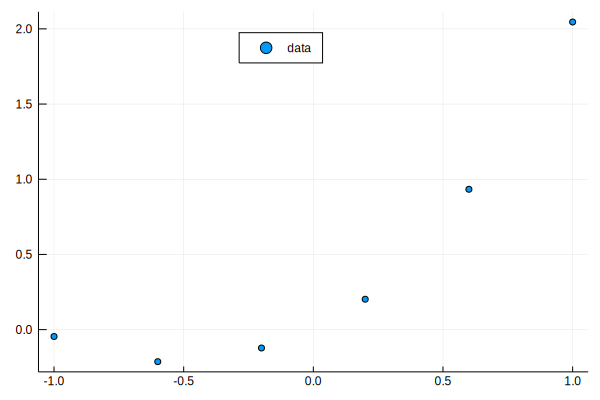

In [2]:
n = 5
t = range(-1,stop=1,length=n+1)
y = @. t^2 + t + 0.05*sin(20*t)

scatter(t,y,label="data",leg=:top)

The polynomial interpolant, as computed using `polyfit`, looks very sensible. It's the kind of function you'd take home to meet your parents.

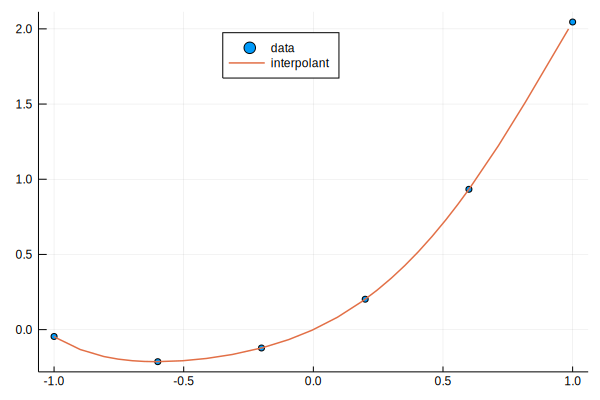

In [3]:
p = polyfit(t,y,n)     # interpolating polynomial
plot!(x->p(x),-1.01,1.01,label="interpolant")

But now consider a different set of points generated in almost exactly the same way.

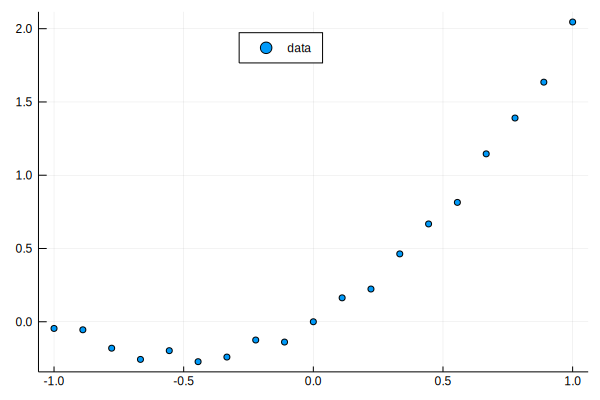

In [4]:
n = 18
t = LinRange(-1,1,n+1)
y = @. t^2 + t + 0.05*sin(20*t)

scatter(t,y,label="data",leg=:top)

The points themselves are unremarkable. But take a look at what happens to the polynomial interpolant.

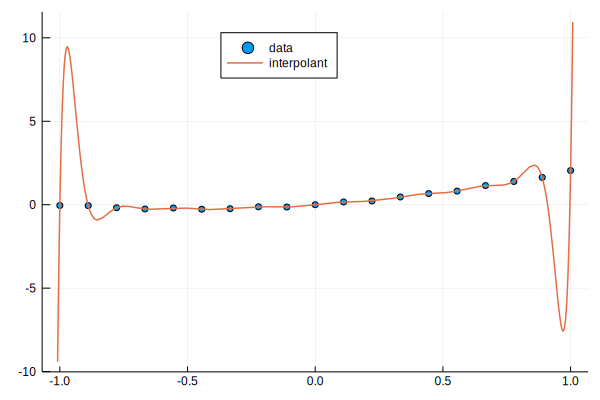

In [5]:
p = polyfit(t,y,n)
plot!(x->p(x),-1.01,1.01,label="interpolant")

Surely there must be functions that are more intuitively representative of those points!

# Example 5.1.3

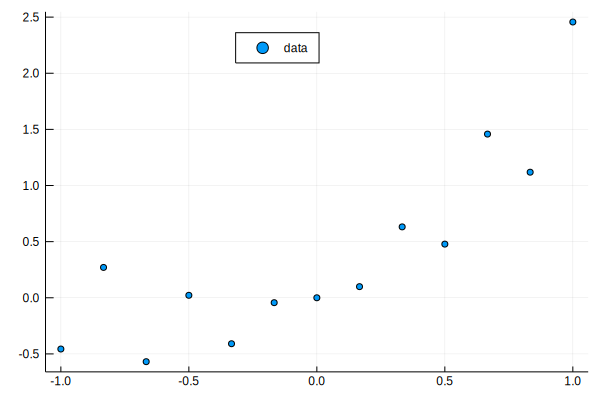

In [6]:
n = 12
t = LinRange(-1,1,n+1)
y = @. t^2 + t + 0.5*sin(20*t)

scatter(t,y,label="data",leg=:top) 

The `Interpolations` package makes it easy to construct some standard interpolating functions. Here is one that is linear between each pair of consecutive nodes.

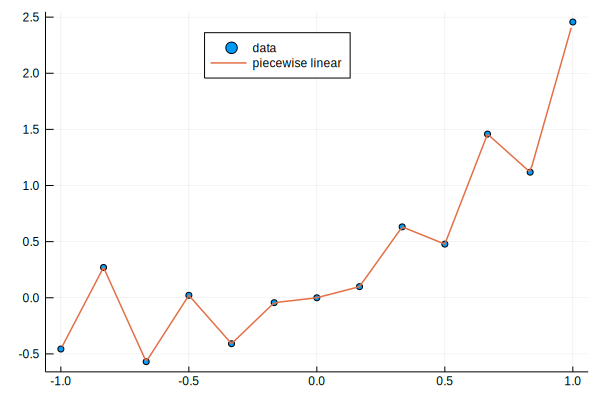

In [7]:
p = LinearInterpolation(t,y)
plot!(x->p(x),-1,1,label="piecewise linear")

We may instead request a smoother interpolant that is piecewise cubic.

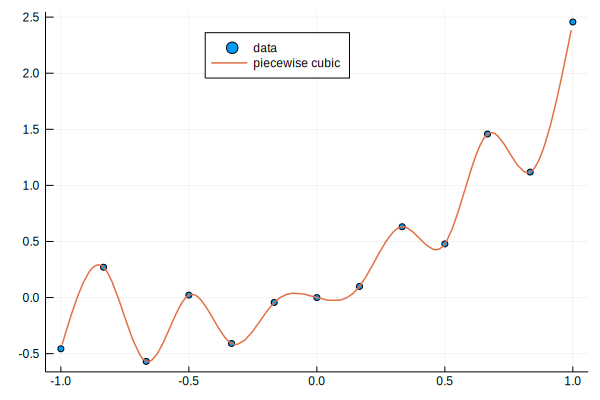

In [8]:
p = CubicSplineInterpolation(t,y)
scatter(t,y,label="data",leg=:top) 
plot!(x->p(x),-1,1,label="piecewise cubic")

# Example 5.1.4

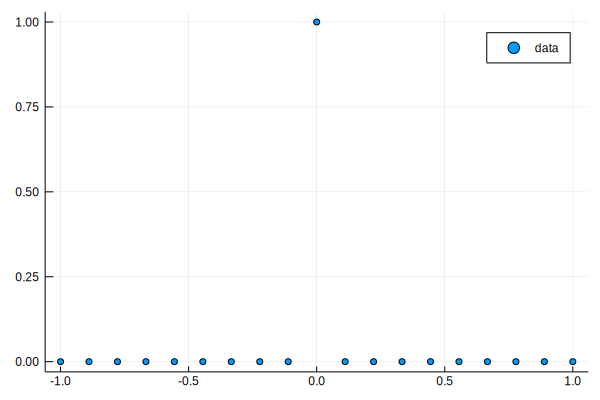

In [9]:
n = 18
t = LinRange(-1,1,n+1)
y = [zeros(9);1;zeros(n-9)];  # data for 10th cardinal function

scatter(t,y,label="data")

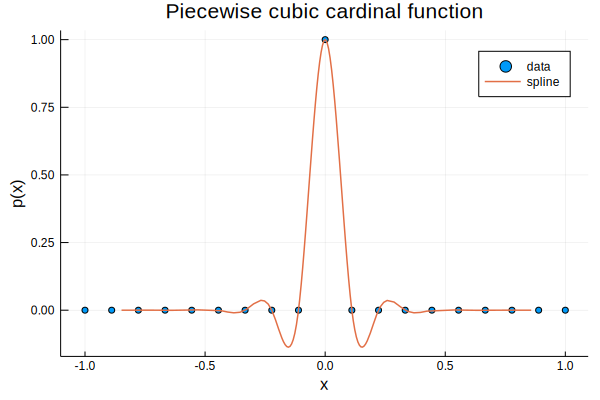

In [10]:
plot!(FNC.spinterp(t,y),label="spline",
    xlabel="x",ylabel="p(x)",title="Piecewise cubic cardinal function")

The piecewise cubic cardinal function is nowhere greater than one in absolute value. This happens to be true for all the cardinal functions, ensuring a good condition number for the interpolation. But the story for global polynomials is very different.

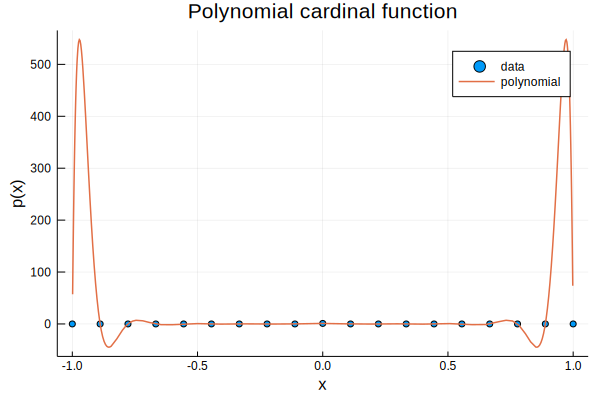

In [11]:
scatter(t,y,label="data")

p = polyfit(t,y,n)
plot!(x->p(x),-1,1,label="polynomial",
    xlabel="x",ylabel="p(x)",title="Polynomial cardinal function")

From the figure we can see that the condition number for polynomial interpolation on these nodes is at least 500. 

# Example 5.2.1

Let's define a set of 6 nodes (i.e., $n=5$ in our formulas). 

In [12]:
t = [0, 0.075, 0.25, 0.55, 0.7, 1]

6-element Array{Float64,1}:
 0.0  
 0.075
 0.25 
 0.55 
 0.7  
 1.0  

We plot the hat functions $H_0,\ldots,H_5$.  

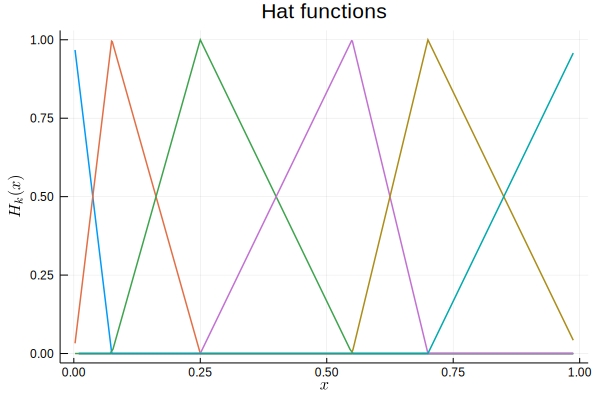

In [13]:
plot([x->FNC.hatfun(x,t,k) for k=0:5],0,1,label="",
    xlabel=L"x", ylabel=L"H_k(x)", title="Hat functions")

# Example 5.2.2

We generate a piecewise linear interpolant of $f(x)=e^{\sin 7x}$. 

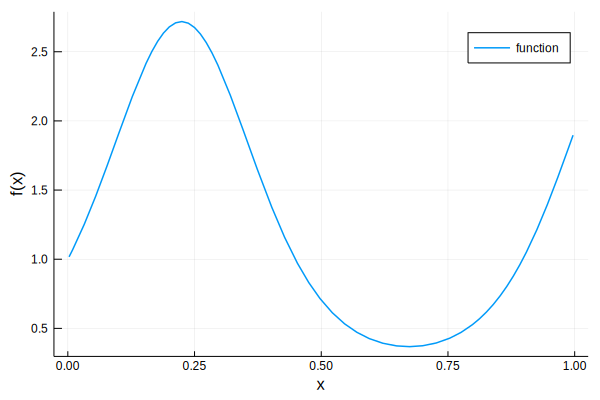

In [14]:
f = x -> exp(sin(7*x))
plot(f,0,1,label="function",
    xlabel="x",ylabel="f(x)")

First we sample the function to create the data.

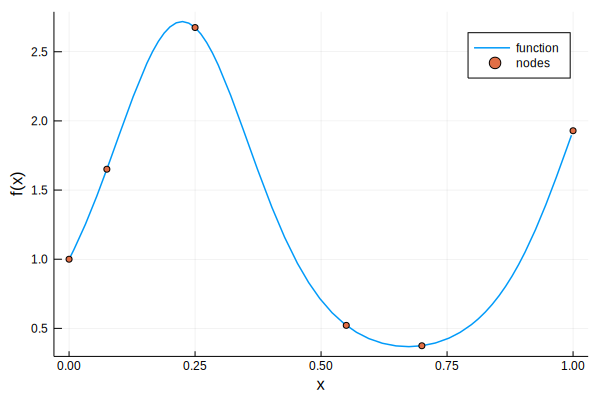

In [15]:
t = [0, 0.075, 0.25, 0.55, 0.7, 1]    # nodes
y = f.(t)                             # function values

scatter!(t,y,label="nodes")

Now we create a callable function that will evaluate the piecewise linear interpolant at any $x$.

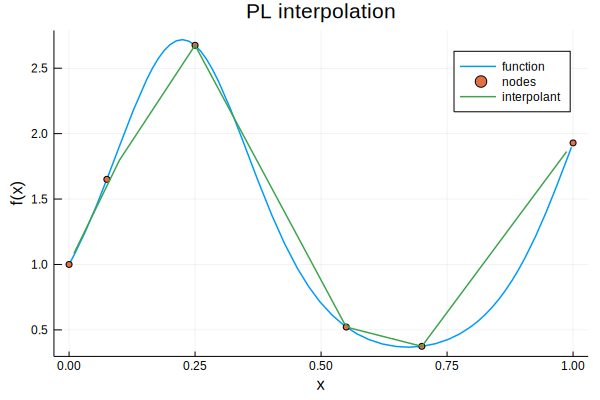

In [16]:
p = FNC.plinterp(t,y)
plot!(p,0,1,label="interpolant",title="PL interpolation")

We measure the convergence rate for piecewise linear interpolation of $e^{\sin 7x}$.

# Example 5.2.3

In [17]:
f = x -> exp(sin(7*x))
x = (0:10000)/1e4  # sample the difference at many points
n = @. 2^(3:10)
err = zeros(size(n))
for (i,n) = enumerate(n)
    t = (0:n)/n   # interpolation nodes
    p = FNC.plinterp(t,f.(t))
    err[i] = maximum( @. abs(f(x)-p(x)) )
end

Since we expect convergence that is $O(h^2)=O(n^{-2})$, we use a log-log graph of error and expect a straight line of slope $-2$.

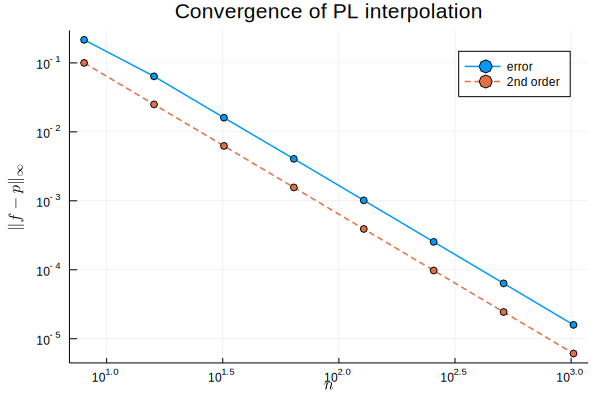

In [18]:
order2 = @. 0.1*(n/n[1])^(-2)
plot(n,[err order2],m=:o,l=[:solid :dash],label=["error" "2nd order"],
    xaxis=(:log10,L"n"),yaxis=(:log10,L"\|f-p\|_\infty"),title="Convergence of PL interpolation")

# Example 5.3.1

For illustration, here is a spline interpolant using just a few nodes. 

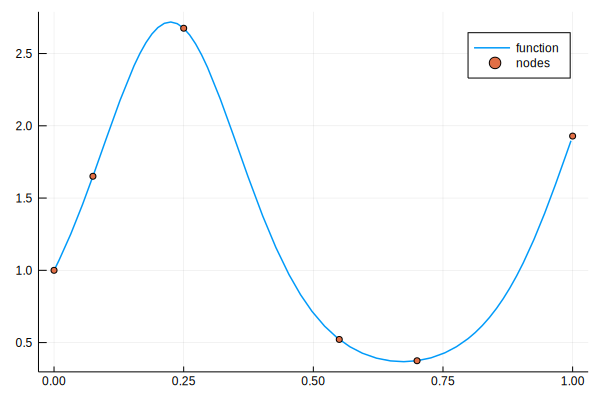

In [19]:
f = x -> exp(sin(7*x))
plot(f,0,1,label="function")

t = [0, 0.075, 0.25, 0.55, 0.7, 1]  # nodes
y = f.(t)                           # values at nodes

scatter!(t,y,label="nodes")

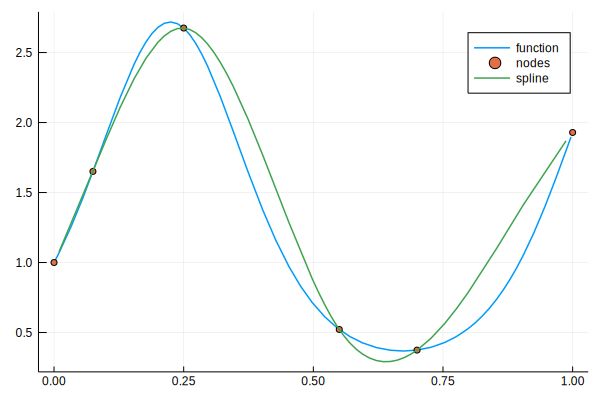

In [20]:
S = FNC.spinterp(t,y)
plot!(S,0,1,label="spline")

Now we look at the convergence rate as the number of nodes increases.

In [21]:
x = (0:10000)/1e4          # sample the difference at many points
n_ = @. round(Int,2^(3:0.5:8))  # numbers of nodes
err_ = zeros(size(n_))
for (i,n) = enumerate(n_)
    t = (0:n)/n 
    S = FNC.spinterp(t,f.(t))
    err_[i] = maximum( @. abs(f(x)-S(x)) )
end

@show err_;

err_ = [0.0305634, 0.0207562, 0.00590761, 0.00134587, 0.000367049, 9.17785e-5, 2.15306e-5, 5.04292e-6, 1.24012e-6, 3.00426e-7, 7.31944e-8]


Since we expect convergence that is $O(h^4)=O(n^{-4})$, we use a log-log graph of error and expect a straight line of slope $-4$.

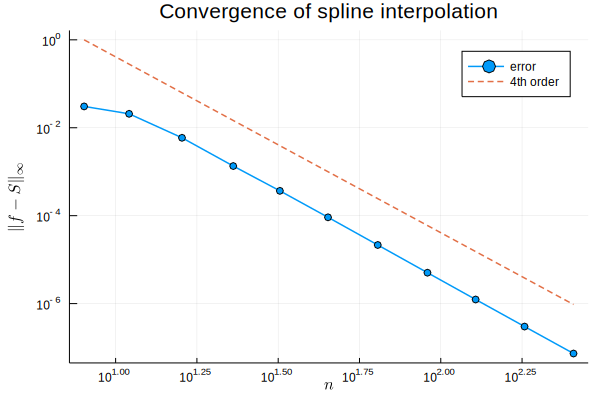

In [22]:
order4 = @. (n_/n_[1])^(-4)
plot(n_,[err_,order4],m=[:o :none],l=[:solid :dash],label=["error","4th order"],
    xaxis=(:log10,L"n"),yaxis=(:log10,L"\| f-S \|_\infty"),
    title="Convergence of spline interpolation")

# Example 5.4.2

We try to estimate the derivative of $\cos(x^2)$ at $x=0.5$ using five nodes. 

In [23]:
t = [ 0.35,0.5,0.57,0.6,0.75 ]   # nodes
f = x -> cos(x^2)
dfdx = x -> -2*x*sin(x^2)
exact_value = dfdx(0.5)

-0.24740395925452294

We have to shift the nodes so that the point of estimation for the derivative is at $x=0$. 

In [24]:
w = FNC.fdweights(t.-0.5,1)

5-element Array{Float64,1}:
  -0.5303030303030298 
 -21.61904761904763   
  45.09379509379508   
 -23.333333333333307  
   0.38888888888888845

In [25]:
fd_value = dot(w,f.(t))

-0.247307422906135

We can reproduce the weights in the finite difference tables by using equally spaced nodes with $h=1$. For example, here is a one-sided formula.

In [26]:
Rational.( FNC.fdweights(0:2,1) )

3-element Array{Rational{Int64},1}:
 -3//2
  2//1
 -1//2

# Example 5.5.2

Let's observe the convergence of the forward-difference formula applied to the function $\sin(e^{x+1})$ at $x=0$. 

In [27]:
f = x -> sin( exp(x+1) );
FD1 = [ (f(0.1)-f(0))   /0.1,
        (f(0.05)-f(0))  /0.05,
        (f(0.025)-f(0)) /0.025 ]

3-element Array{Float64,1}:
 -2.737868275809363 
 -2.6127952856136947
 -2.5464969752366606

It's not clear that the sequence is converging. As predicted, however, the errors are cut approximately by a factor of 2 when $h$ is divided by 2.

In [28]:
exact_value = cos(exp(1))*exp(1)
err = @. exact_value - FD1

3-element Array{Float64,1}:
 0.25951854285412823
 0.1344455526584598 
 0.06814724228142577

Asymptotically as $h\to0$, the error is proportional to $h$.

# Example 5.5.4

In [29]:
f = x -> sin( exp(x+1) );
exact_value = cos(exp(1))*exp(1);

We'll run both formulas in parallel for a sequence of $h$ values.

In [30]:
h_ = @. 4. ^(-1:-1:-8)
FD1 = 0*h_;  FD2 = 0*h_;
for (k,h) = enumerate(h_)
    FD1[k] = (f(h) - f(0)) / h
    FD2[k] = (f(h) - f(-h)) / (2*h)
end

In each case $h$ is decreased by a factor of 4, so that the error is reduced by a factor of 4 in the first-order method and 16 in the second-order method.

In [31]:
error_FD1 = @. exact_value-FD1 
error_FD2 = @. exact_value-FD2

DataFrame(h=h_,error_FD1=error_FD1,error_FD2=error_FD2)   

,h,error_FD1,error_FD2
,Float64,Float64,Float64
1,0.25,0.53167,-0.0858972
2,0.0625,0.166752,-0.00444383
3,0.015625,0.042784,-0.000274029
4,0.00390625,0.0107514,-1.71123e-5
5,0.000976563,0.00269113,-1.06946e-6
6,0.000244141,0.000672984,-6.68411e-8
7,6.10352e-5,0.000168259,-4.1767e-9
8,1.52588e-5,4.20654e-5,-2.72689e-10


A graphical comparison can be clearer. On a log-log scale, the error should (roughly) be a straight line whose slope is the order of accuracy. However, it's conventional in convergence plots, to show $h$ _decreasing_ from left to right, which negates the slopes.

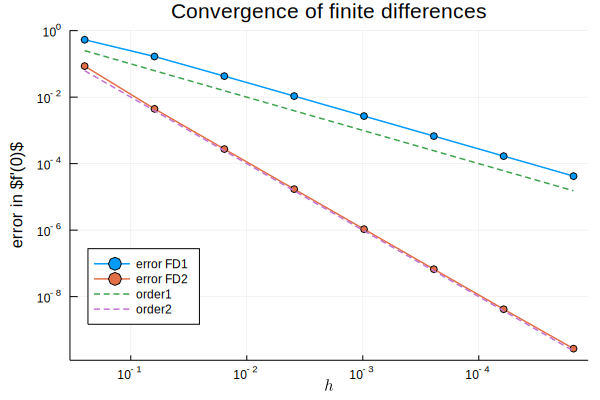

In [32]:
plot(h_,[abs.(error_FD1) abs.(error_FD2)],m=:o,label=["error FD1" "error FD2"],
    xflip=true,xaxis=(:log10,"\$h\$"),yaxis=(:log10,"error in \$f'(0)\$"),
    title="Convergence of finite differences",leg=:bottomleft)
plot!(h_,[h_ h_.^2],l=:dash,label=["order1" "order2"])      # perfect 1st and 2nd order 

# Example 5.5.5

Let $f(x)=e^{-1.3x}$. We apply finite difference formulas of first, second, and fourth order to estimate $f'(0)=-1.3$.

In [33]:
h = @. 1/10^(1:12)
f = x -> exp(-1.3*x);
fd1 = zeros(size(h))
fd2 = zeros(size(h))
fd4 = zeros(size(h))
for (j,h) = enumerate(h) 
    nodes = h*(-2:2)
    vals = @. f(nodes)/h
    fd1[j] = dot([   0    0 -1    1     0],vals)
    fd2[j] = dot([   0 -1/2  0  1/2     0],vals)
    fd4[j] = dot([1/12 -2/3  0  2/3 -1/12],vals)
end

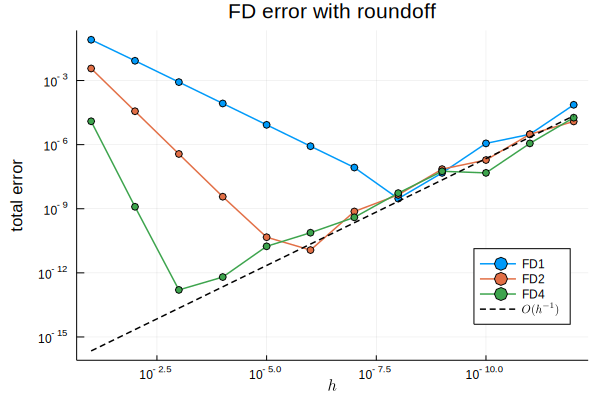

In [34]:
plot(h,abs.(fd1.+1.3),m=:o,label="FD1",
    xaxis=(:log10,"\$h\$"),xflip=true,yaxis=(:log10,"total error"),
    title="FD error with roundoff",legend=:bottomright)
plot!(h,abs.(fd2.+1.3),m=:o,label="FD2")
plot!(h,abs.(fd4.+1.3),m=:o,label="FD4")
plot!(h,0.1*eps()./h,l=:dash,color=:black,label="\$O(h^{-1})\$")

Again the graph is made so that $h$ decreases from left to right. The errors are dominated at first by truncation error, which decreases most rapidly for the 4th order formula. However, increasing roundoff error eventually equals and then dominates the truncation error as $h$ continues to decrease. As the order of accuracy increases, the crossover point moves to the left (greater efficiency) and down (greater accuracy). 

# Example 5.6.1

The antiderivative of $e^x$ is, of course, itself. That makes evaluation of $\int_0^1 e^x\,dx$ by the Fundamental Theorem trivial.

In [35]:
I = exp(1)-1

1.718281828459045

The Julia package `QuadGK` has a good all-purpose numerical integrator that estimates the value numerically without finding the antiderivative first. As you can see here, it's often just as accurate. 

In [36]:
Q,errest = quadgk(x->exp(x),0,1)
@show Q;

Q = 1.718281828459045


The numerical approach is far more robust. For example, $e^{\sin x}$ has no useful antiderivative. But numerically it's no more difficult. 

In [37]:
Q,errest = quadgk(x->exp(sin(x)),0,1)
@show Q;

Q = 1.6318696084180515


When you look at the graphs of these functions, what's remarkable is that one of these areas is the most basic calculus while the other is almost impenetrable analytically. From a numerical standpoint, they are practically the same problem.

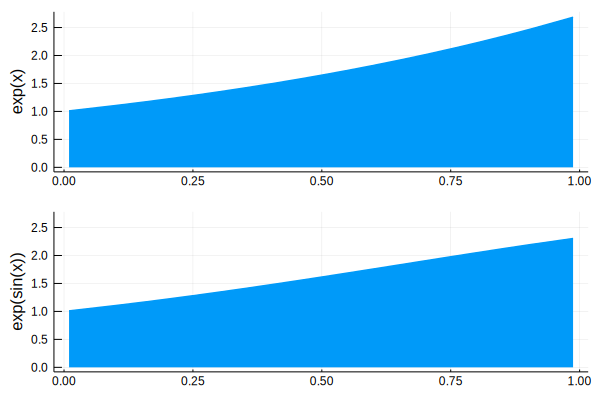

In [38]:
plot([exp,x->exp(sin(x))],0,1,fill=0,leg=:none,
    ylabel=["exp(x)" "exp(sin(x))"],ylim=[0,2.7],layout=(2,1))

# Example 5.6.2

We approximate the integral of the function $f(x)=e^{\sin 7x}$ over the interval $[0,2]$. 

In [39]:
f = x -> exp(sin(7*x));
a = 0;  b = 2;

In lieu of the exact value, we will use the `QuadGK` package to find an accurate result.

In [40]:
I,errest = quadgk(f,a,b,atol=1e-14,rtol=1e-14);
println("Integral = $I")

Integral = 2.6632197827615394


Here is the error at $n=40$. 

In [41]:
T,t,y = FNC.trapezoid(f,a,b,40)
@show T;
@show err = I - T;

T = 2.6623029356022876
err = I - T = 0.0009168471592517768


In order to check the order of accuracy, we double $n$ a few times and observe how the error decreases.

In [42]:
n = @. 40*2^(0:5)
err = zeros(size(n));
for (k,n) = enumerate(n)
    T,t,y = FNC.trapezoid(f,a,b,n)
    err[k] = I - T
end
DataFrame(n=n,error=err)

,n,error
,Int64,Float64
1,40,0.000916847
2,80,0.000230065
3,160,5.75676e-5
4,320,1.43951e-5
5,640,3.59897e-6
6,1280,8.99754e-7


Each doubling of $n$ cuts the error by a factor of about 4, which is consistent with second-order convergence. Another check: the slope on a log-log graph should be $-2$.

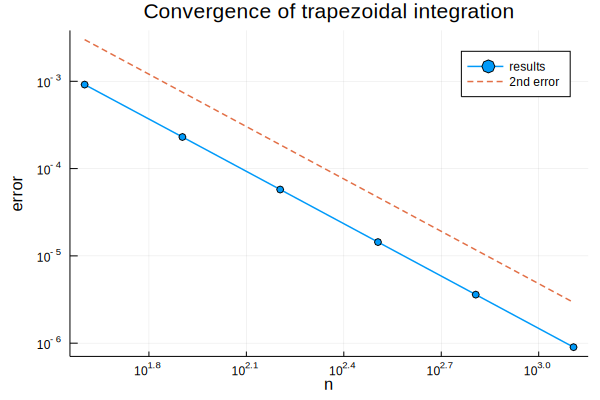

In [43]:
plot(n,abs.(err),m=:o,label="results",
    xaxis=(:log10,"n"),yaxis=(:log10,"error"),title="Convergence of trapezoidal integration")
plot!(n,3e-3*(n/n[1]).^(-2),l=:dash,label="2nd error")

# Example 5.6.3

We estimate $\displaystyle\int_0^2 x^2 e^{-2x}\, dx$ using extrapolation. 

In [44]:
f = x -> x^2*exp(-2*x);
a = 0;  b = 2; 
I,errest = quadgk(f,a,b,atol=1e-14,rtol=1e-14)

(0.1904741736116139, 1.4432899320127035e-15)

We start with the trapezoid formula on $n=N$ nodes.

In [45]:
N = 20;       # the coarsest formula
n = N;  h = (b-a)/n;
t = h*(0:n);   y = f.(t);

We can now apply weights to get the estimate $T_f(N)$. 

In [46]:
T = [h*( sum(y[2:n]) + y[1]/2 + y[n+1]/2 )]
err_2nd = I .- T

1-element Array{Float64,1}:
 6.272367234605447e-5

Now we double to $n=2N$, but we only need to evaluate $f$ at every other interior node.

In [47]:
n = 2*n;  h = h/2;  t = h*(0:n);
T = [ T; T[1]/2 + h*sum( f.(t[2:2:n]) ) ]
err_2nd = I .- T

2-element Array{Float64,1}:
 6.272367234605447e-5 
 1.5367752102146692e-5

As expected for a second-order estimate, the error went down by a factor of about 4. We can repeat the same code to double $n$ again.

In [48]:
n = 2*n;  h = h/2;  t = h*(0:n);
T = [ T; T[2]/2 + h*sum( f.(t[2:2:n]) ) ]
err_2nd = I .- T

3-element Array{Float64,1}:
 6.272367234605447e-5 
 1.5367752102146692e-5
 3.822306969603062e-6 

Let us now do the first level of extrapolation to get results from Simpson's formula. We combine the elements `T[i]` and `T[i+1]` the same way for $i=1$ and $i=2$.

In [49]:
S = [ (4*T[i+1]-T[i])/3 for i=1:2 ]
err_4th = I .- S

2-element Array{Float64,1}:
 -4.175546458318191e-7
 -2.617474123556285e-8

With the two Simpson values $S_f(N)$ and $S_f(2N)$ in hand, we can do one more level of extrapolation to get a 6th-order accurate result.

In [50]:
R = (16*S[2] - S[1]) / 15
err_6th = I .- R

-8.274761431614763e-11

If we consider the computational time to be dominated by evaluations of $f$, then we have obtained a result with twice as many accurate digits as the best trapezoid result, at virtually no extra cost.

# Example 5.7.1

This function gets increasingly oscillatory near the right endpoint.

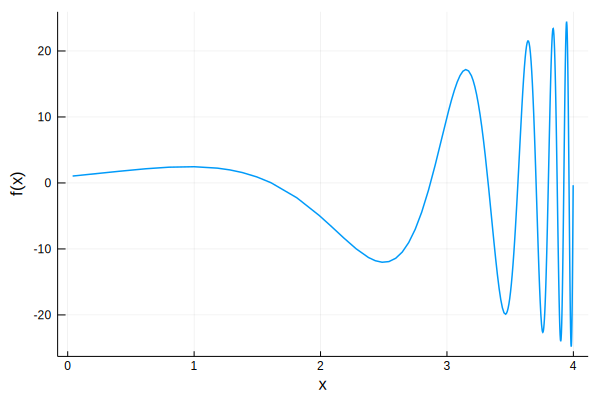

In [51]:
f = x -> (x+1)^2*cos((2*x+1)/(x-4.3))
plot(f,0,4,label="",xlabel="x",ylabel="f(x)")

Accordingly, the trapezoid rule is more accurate on the left half of the interval than on the right half.

In [52]:
n = @. 50*2^(0:3)
Tleft = []; Tright = [];
for (i,n) = enumerate(n)
    Tleft = [ Tleft; FNC.trapezoid(f,0,2,n)[1] ] 
    Tright = [ Tright; FNC.trapezoid(f,2,4,n)[1] ] 
end

In [53]:
left_val,err = quadgk(f,0,2,atol=1e-14,rtol=1e-14)
right_val,err = quadgk(f,2,4,atol=1e-14,rtol=1e-14)

DataFrame(n=n,left_error=Tleft.-left_val,right_error=Tright.-right_val)

,n,left_error,right_error
,Int64,Float64,Float64
1,50,-0.00249106,0.504229
2,100,-0.000622715,0.0960044
3,200,-0.000155675,0.0225473
4,400,-3.89187e-5,0.00555422


Both the picture and the numbers suggest that more nodes should be used on the right half of the interval than on the left half.

# Example 5.7.2

In [54]:
f = x -> (x+1)^2*cos((2*x+1)/(x-4.3));
@show I,errest = quadgk(f,0,4,atol=1e-14,rtol=1e-14);  # 'exact' value

(I, errest) = quadgk(f, 0, 4, atol=1.0e-14, rtol=1.0e-14) = (-2.825533373437446, 2.1510571102112408e-14)


We perform the integration and show the nodes selected underneath the curve. 

num_nodes = length(t) = 69


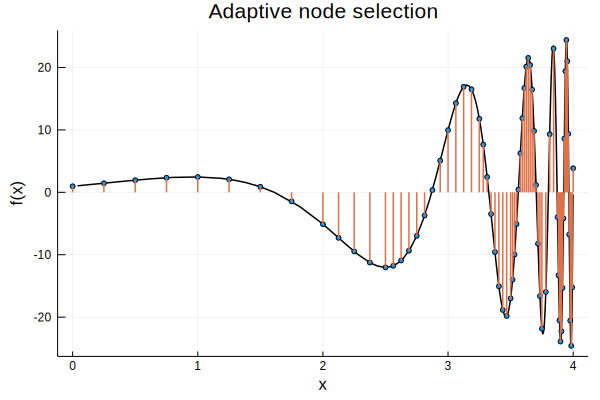

In [55]:
Q,t = FNC.intadapt(f,0,4,0.001)
@show num_nodes = length(t);

plot(f,0,4,color=:black,legend=:none,
    xlabel="x",ylabel="f(x)",title="Adaptive node selection")
plot!(t,f.(t),seriestype=:sticks,m=(:o,2))

The error turns out to be a bit more than we requested. It's only an estimate, not a guarantee.

In [56]:
@show err = I - Q;

err = I - Q = -0.022002813037627078


Let's see how the number of integrand evaluations and the error vary with the requested tolerance.

In [57]:
tol_ = @. 10.0^(-4:-1:-14)
err_ = zeros(size(tol_))
num_ = zeros(Int,size(tol_))
for i = 1:length(tol_)
    Q,t = FNC.intadapt(f,0,4,tol_[i])
    err_[i] = I - Q
    num_[i] = length(t)
end
DataFrame(tol=tol_,error=err_,f_evals=num_)

,tol,error,f_evals
,Float64,Float64,Int64
1,0.0001,-0.000419469,113
2,1.0e-5,4.78977e-5,181
3,1.0e-6,6.31438e-6,297
4,1.0e-7,-6.63925e-7,489
5,1.0e-8,7.18081e-8,757
6,1.0e-9,1.26524e-8,1193
7,1.0e-10,-8.44126e-10,2009
8,1.0e-11,2.61271e-11,3157
9,1.0e-12,4.04463e-11,4797


As you can see, even though the errors are not less than the estimates, the two columns decrease in tandem. If we consider now the convergence not in $h$ (which is poorly defined) but in the number of nodes actually chosen, we come close to the fourth order accuracy of the underlying Simpson scheme.

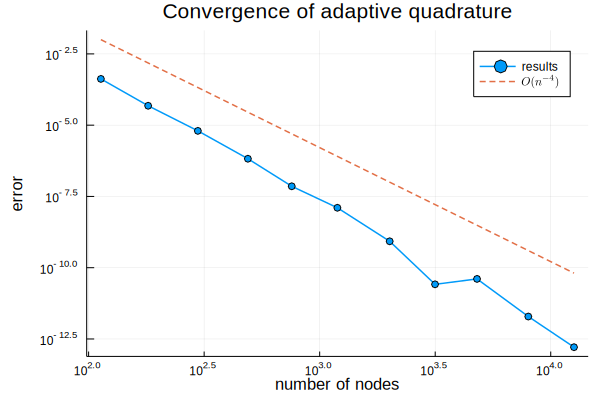

In [58]:
plot(num_,abs.(err_),m=:o,label="results",
    xaxis=(:log10,"number of nodes"),yaxis=(:log10,"error"),
    title="Convergence of adaptive quadrature")
order4 = @. 0.01*(num_/num_[1])^(-4)
plot!(num_,order4,l=:dash,label="\$O(n^{-4})\$")